In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta, datetime

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())
#or
from sqlalchemy import inspect
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']


['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

measurement.metadata.tables['measurement']

Table('measurement', MetaData(), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None)

In [8]:
station.metadata.tables['station']

Table('station', MetaData(), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
#order the table by descending date, print first row
most_recent_date= session.query(measurement.date).order_by(measurement.date.desc()).first()[0]

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_datetime = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

one_year_from_most_recent = most_recent_datetime - dt.timedelta(days=365)

print(most_recent_datetime)
print(one_year_from_most_recent)

# Perform a query to retrieve the date and precipitation scores

data = session.query(measurement.date, measurement.prcp)\
        .filter(measurement.date >= one_year_from_most_recent).all()
    
# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(data, columns=['Date', 'Percipitation'])

# Sort the dataframe by date and checking my values and start/end dates in the dataframe
prcp_df = prcp_df.sort_values('Date', ascending=True).reset_index(drop=True)

# checking df values, rows, types
print(prcp_df.head(1))
print(prcp_df.tail(1))
print(prcp_df['Date'].dtypes)
print(prcp_df['Percipitation'].dtypes)

2017-08-23 00:00:00
2016-08-23 00:00:00
         Date  Percipitation
0  2016-08-24           0.08
            Date  Percipitation
2222  2017-08-23           0.45
object
float64


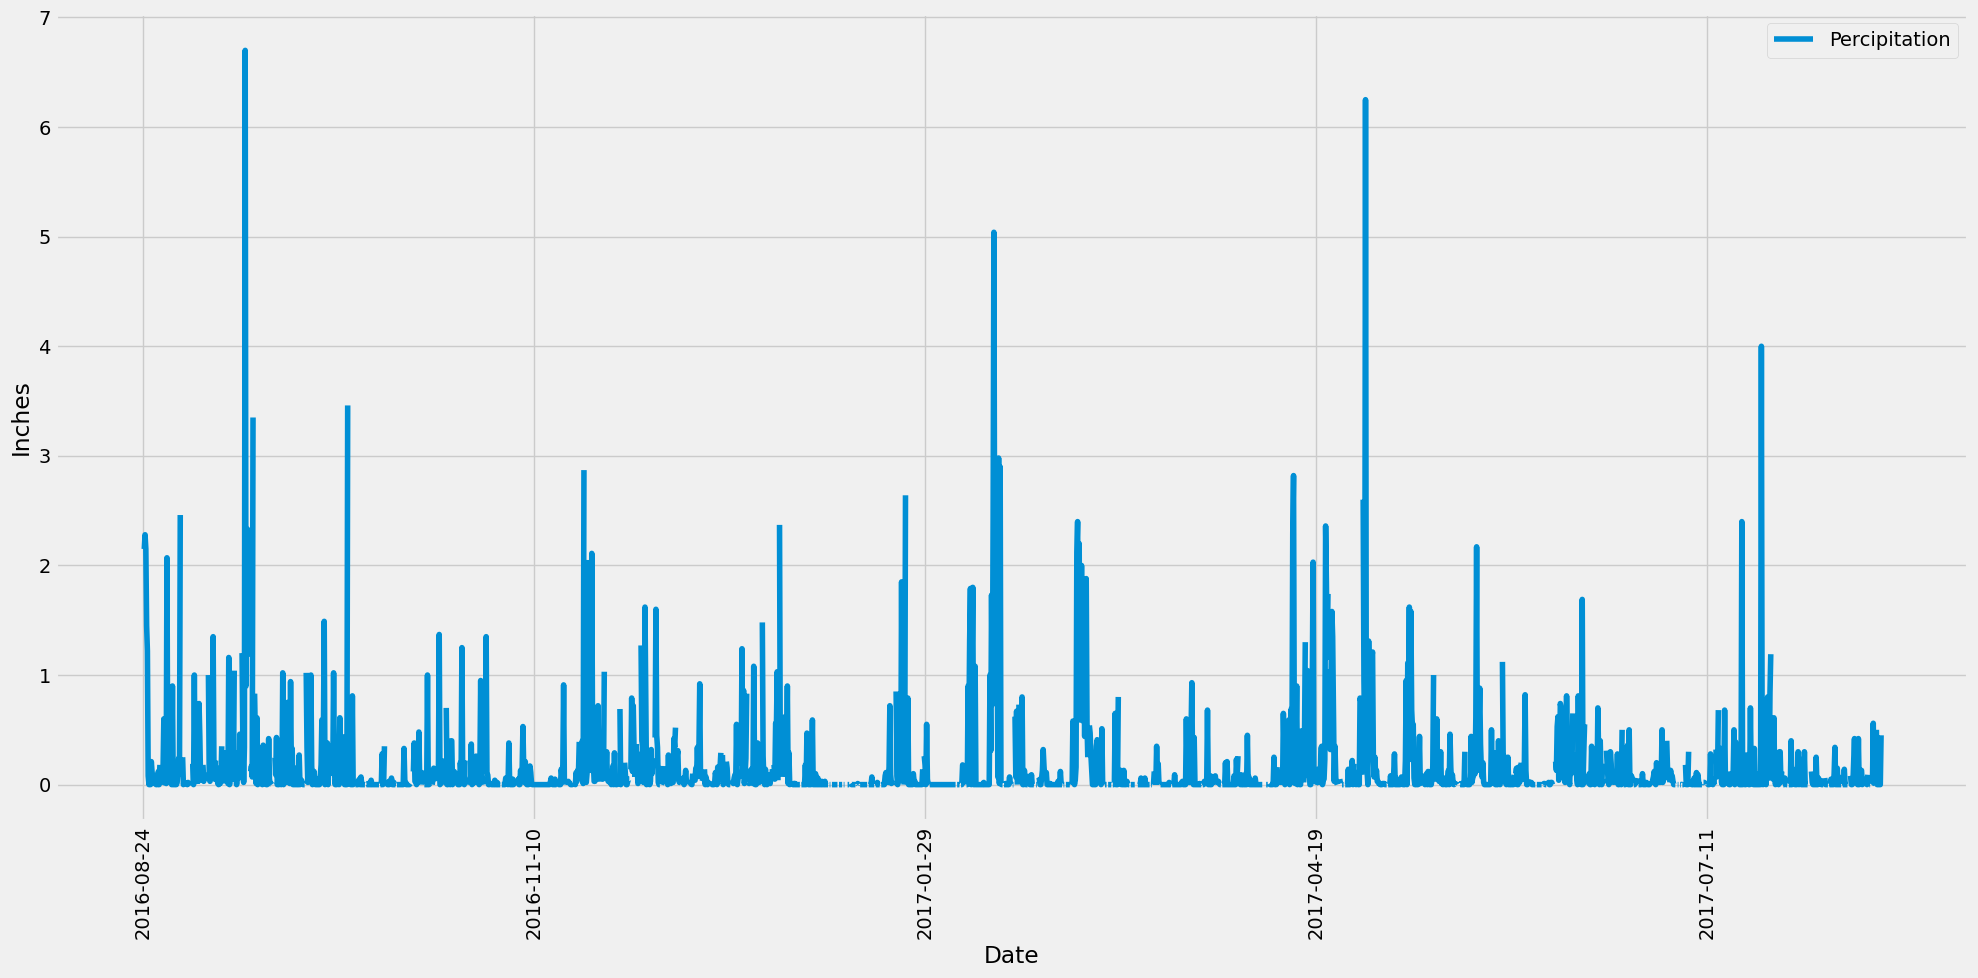

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x="Date", y="Percipitation", kind="line", rot=90, figsize=(20, 10))

# set plot title and labels
plt.xlabel("Date")
plt.ylabel("Inches")
plt.tight_layout()

# display the plot
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_stats = prcp_df['Percipitation'].describe()

# Print the summary statistics
print(prcp_stats)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Percipitation, dtype: float64


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_number_stations = session.query(station.id).count()
print(total_number_stations)

9


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(measurement.station, func.count(measurement.station))\
                        .group_by(measurement.station)\
                        .order_by(func.count(measurement.station).desc())\
                        .all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [measurement.station, 
       func.min(measurement.tobs), 
       func.max(measurement.tobs), 
       func.avg(measurement.tobs)]

session.query(*sel)\
    .filter(measurement.station == "USC00519281")\
    .group_by(measurement.station)\
    .order_by(measurement.station)\
    .all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

       station  tobs
0  USC00519281  77.0
         station  tobs
350  USC00519281  79.0


Text(0.5, 0, 'Temperature')

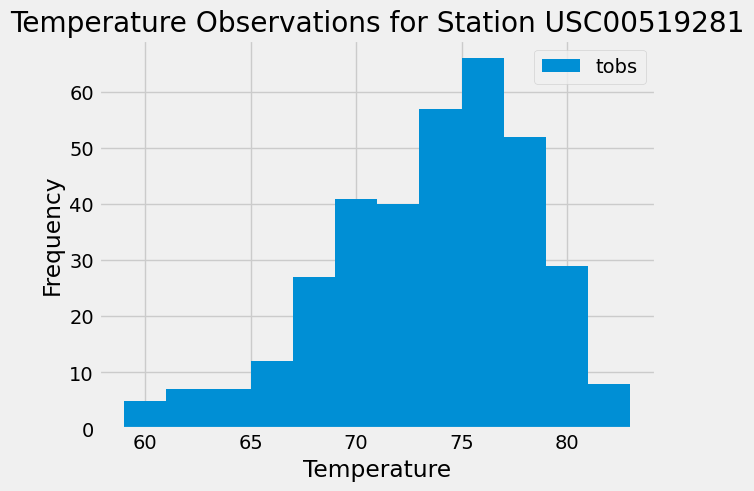

In [17]:
#selecting the columns of interest
sel = [measurement.station, 
       measurement.tobs]

#filtering based on specific station id and measurement date(taken from above)
temperature_data = session.query(*sel)\
    .filter(measurement.station == "USC00519281")\
    .filter(measurement.date >= one_year_from_most_recent).all()

#creating a df from the temperature data
temperature_df = pd.DataFrame(temperature_data)

#checking to see that the df has all the expected values
print(temperature_df.head(1))
print(temperature_df.tail(1))

#plot the df as a histogram
temperature_df.plot(kind='hist', bins=12)
plt.title("Temperature Observations for Station USC00519281")
plt.xlabel("Temperature")

# Close Session

In [18]:
#Close Session
session.close()